In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from termcolor import cprint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [46]:
path='/Users/Shark/Encore/ML/titanic_challenge'
test_df = pd.read_csv('data/test.csv')
train_df = pd.read_csv('data/train.csv')
#full_df = pd.read_csv('data/full.csv')

In [15]:
full_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'WikiId', 'Name_wiki',
       'Age_wiki', 'Hometown', 'Boarded', 'Destination', 'Lifeboat', 'Body',
       'Class'],
      dtype='object')

In [17]:
full_df = full_df[['PassengerId', 'Lifeboat']]

In [23]:
full_df.columns = full_df.columns.str.lower()

In [26]:
#train_df.set_index('passengerid', inplace=True)
#test_df.set_index('passengerid', inplace=True)
full_df.set_index('passengerid', inplace=True)

In [47]:
full_df

,lifeboat
passengerid,
1,NaN
2,4
3,14?
4,D
5,NaN
...,...
1305,NaN
1306,8
1307,NaN


In [49]:
train_df = train_df.join(full_df)

In [50]:
test_df = test_df.join(full_df)

In [94]:
X = train_df.copy()
X_test_data = test_df.copy()

In [52]:
test_df

,passengerid,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,lifeboat
0,916,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q,NaN
1,917,2,"Pinsky, Mrs. (Rosa)",female,32.0,0,0,234604,13.0000,NaN,S,NaN
2,918,3,"McCarthy, Miss. Catherine Katie""""",female,NaN,0,0,383123,7.7500,NaN,Q,4
3,919,3,"Franklin, Mr. Charles (Charles Fardon)",male,NaN,0,0,SOTON/O.Q. 3101314,7.2500,NaN,S,14?
4,920,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S,D
...,...,...,...,...,...,...,...,...,...,...,...,...
388,1304,3,"Healy, Miss. Hanora ""Nora""",female,NaN,0,0,370375,7.7500,NaN,Q,9
389,1305,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,111361,57.9792,B18,C,NaN
390,1306,3,"Ayoub, Miss. Banoura",female,13.0,0,0,2687,7.2292,NaN,C,12
391,1307,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S,C


In [95]:
cprint("Cardinality of categorical columns:","green")
for c in X.columns:
    if X[c].dtype == "object":
        print(c, X[c].nunique())

# It appears that some have very high cardinality, so i will make a list of them and examine them later
high_cardinality_cols = [cname for cname in X.columns if X[cname].nunique() > 10 and 
                        X[cname].dtype == "object"]

cprint(" Columns with high cardinality are:", "green")
print(high_cardinality_cols)

Cardinality of categorical columns:
name 915
gender 2
ticket 703
cabin 146
embarked 3
lifeboat 22
 Columns with high cardinality are:
['name', 'ticket', 'cabin', 'lifeboat']


In [96]:
# The cabin feature has huge cardinality, and the vast majority of its data points is missing. There are 2 scenarios. Either the data is lost so i better drop this column, or missing data points belong to passengers that did not had a cabin at all
# In case the latter is True, then cabin is an important feature and i will use it

#Because of its high cardinality, i will construct an new feature "Hascabin". If the passenger had one then its value is 1, else it is 0
for i in X["cabin"]:
    X['Hascabin'] = (X['cabin'].notnull().astype('int'))

for i in X_test_data["cabin"]:
    X_test_data['Hascabin'] = (X_test_data['cabin'].notnull().astype('int'))    

# Now i can drop the original "cabin" column as it is useless
X.drop(["cabin"], axis=1, inplace=True)
X_test_data.drop(["cabin"], axis=1, inplace=True)

In [97]:
# Handling missing data of the "age" feature in both X and X_test_data
# Here, i replace NaN values in both X and X_test_data with the Column's median
X["age"].fillna(X.groupby(["pclass", "gender"])["age"].transform("mean"), inplace=True)
X_test_data["age"].fillna(X_test_data.groupby(["pclass", "gender"])["age"].transform("mean"), inplace=True)

In [62]:
X.embarked.fillna(X.embarked.mode(), inplace=True)

In [63]:
X_test_data.embarked.fillna(X.embarked.mode(), inplace=True)

In [73]:
emb_mode = X_test_data.embarked.value_counts()

In [98]:
X.isnull().sum()

passengerid      0
survived         0
pclass           0
name             0
gender           0
age              0
sibsp            0
parch            0
ticket           0
fare             0
embarked         1
lifeboat       559
Hascabin         0
dtype: int64

In [92]:
# Handling of missing data of the "embarked" feature in both X and X_test_data (the latter does not have any missing data)

# These observations contain null values in the embarked feature, so i will Label Encode them manually with the map() function
emb_map = {'S':0,'C':1,'Q':2}
X.embarked = X.embarked.map(emb_map)
X_test_data.embarked = X_test_data.embarked.map(emb_map).astype(int)

# I will fill the two NaN's with the column's median
print("mean of embarked column:",X.embarked.median())
X.embarked.fillna(X.embarked.median(), inplace = True)
X.embarked = X.embarked.astype(int)

mean of embarked column: nan


/Users/Shark/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/Shark/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [102]:
X.embarked.fillna('S', inplace = True)

In [103]:
X_test_data.embarked.fillna('S', inplace = True)

In [105]:
X_test_data.isnull().sum()

passengerid      0
pclass           0
name             0
gender           0
age              0
sibsp            0
parch            0
ticket           0
fare             1
embarked         0
lifeboat       239
Hascabin         0
dtype: int64

In [106]:
emb_map = {'S':0,'C':1,'Q':2}
X.embarked = X.embarked.map(emb_map)
X_test_data.embarked = X_test_data.embarked.map(emb_map).astype(int)

In [108]:
X_test_data["fare"].fillna(X.groupby(['pclass', 'gender'])['fare'].transform("median"), inplace=True)

In [109]:
print(X.info())
print(X_test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  916 non-null    int64  
 1   survived     916 non-null    int64  
 2   pclass       916 non-null    int64  
 3   name         916 non-null    object 
 4   gender       916 non-null    object 
 5   age          916 non-null    float64
 6   sibsp        916 non-null    int64  
 7   parch        916 non-null    int64  
 8   ticket       916 non-null    object 
 9   fare         916 non-null    float64
 10  embarked     916 non-null    int64  
 11  lifeboat     357 non-null    object 
 12  Hascabin     916 non-null    int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 93.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pas

/var/folders/5l/zhxf24nx12x4g17npl9y29700000gn/T/ipykernel_61451/1357558032.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = X.corr()


Text(0.5, 1.0, 'Correlation Map')

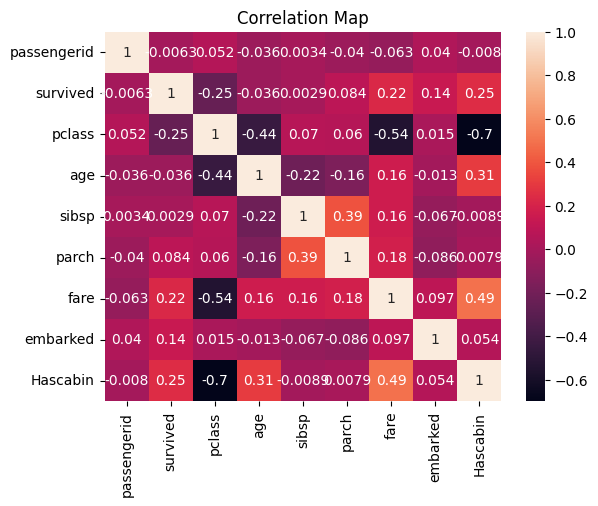

In [110]:
# Some basic Exploratory data analysis
corr = X.corr()
sns.heatmap(corr, annot = True).set_title("Correlation Map")

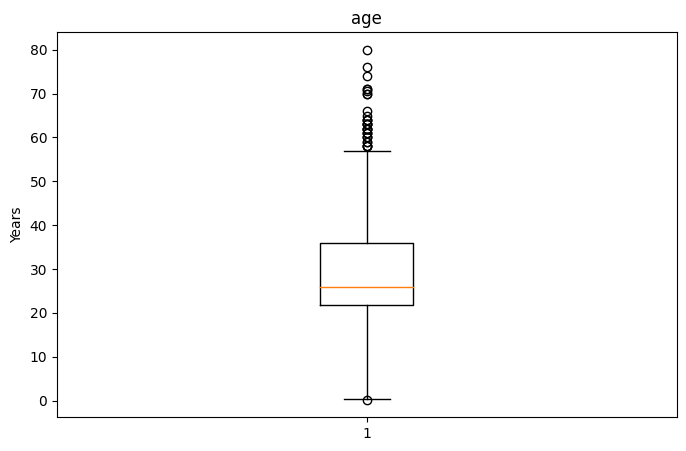

In [112]:
#Age analysis

fig = plt.figure(figsize =(8, 5))
plt.boxplot(X["age"])
plt.title('age')
plt.ylabel('Years')
plt.show()

In [114]:
# These are the bins
# I may toggle them later to see how my model accuracy will react
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, np.inf]

#Binning the X
X["agebins"] = pd.cut(X["age"], bins)

#Binning the X_test_data
X_test_data["agebins"] = pd.cut(X_test_data["age"], bins)

In [115]:
label_encoder = LabelEncoder()

# Encode labels in column AgeBins in X 
X['agebins'] = label_encoder.fit_transform(X["agebins"])

# Encode labels in column AgeBins in X_test_data
X_test_data["agebins"] = label_encoder.fit_transform(X_test_data["agebins"])

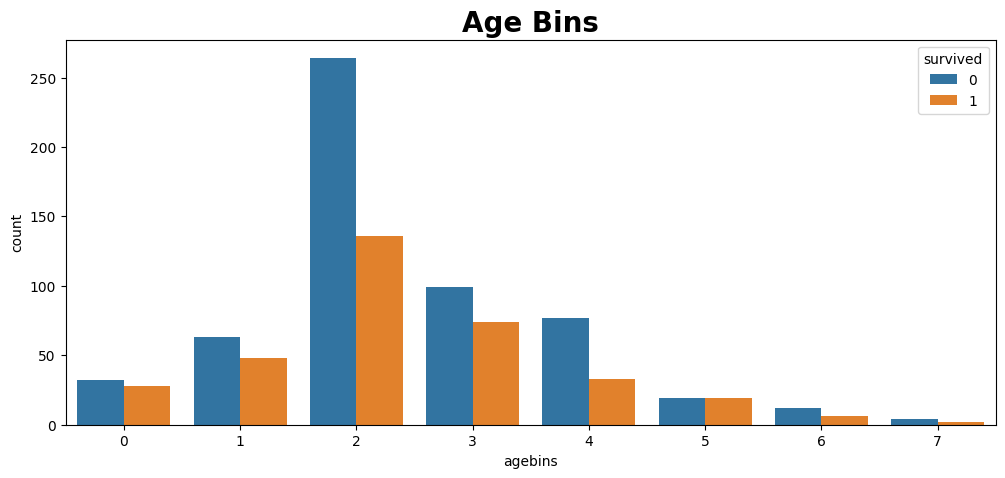

In [116]:
fig, axs = plt.subplots(figsize=(12, 5))
sns.countplot(x=X["agebins"], hue='survived', data=X).set_title("Age Bins",fontdict= { 'fontsize': 20, 'fontweight':'bold'});

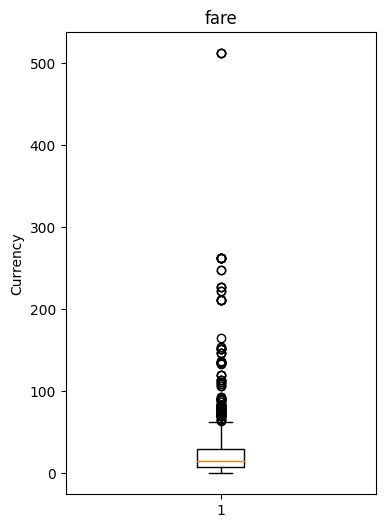

In [117]:
#Fare analysis

fig = plt.figure(figsize =(4, 6))
plt.boxplot(X["fare"])
plt.title('fare')
plt.ylabel('Currency')
plt.show()

In [118]:
# We will bin this feature, but i will toggle the bin's boundaries later to see how our models will react
bins = [0, 50, 100,  200,  300,  400,  500, np.inf]

#Binning the X
X["farebins"] = pd.cut(X["fare"], bins)
#Binning the X_test_data
X_test_data["farebins"] = pd.cut(X_test_data["fare"], bins)

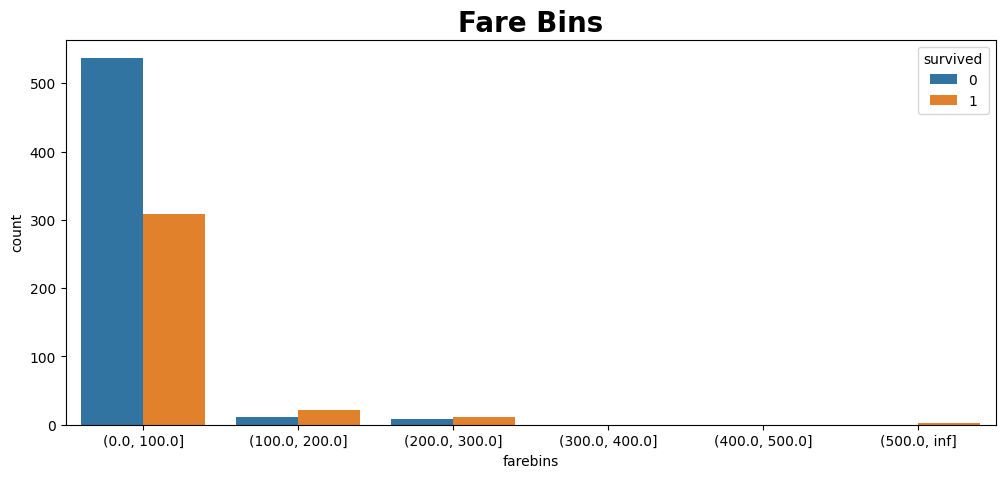

In [119]:
fig, axs = plt.subplots(figsize=(12, 5))
sns.countplot(x=X["farebins"], hue='survived', data=X).set_title("Fare Bins",fontdict= { 'fontsize': 20, 'fontweight':'bold'});

In [120]:
# Encode labels in column FareBins in X 
X['farebins'] = label_encoder.fit_transform(X["farebins"])

# Encode labels in column AgeBins in X_test_data
X_test_data["farebins"] = label_encoder.fit_transform(X_test_data["farebins"])

In [121]:
# Sex analysis

gender_mapping = {'female':0,'male':1}
# In X 
X.gender = X.gender.map(gender_mapping)
# In X_test_data
X_test_data.gender = X_test_data.gender.map(gender_mapping)

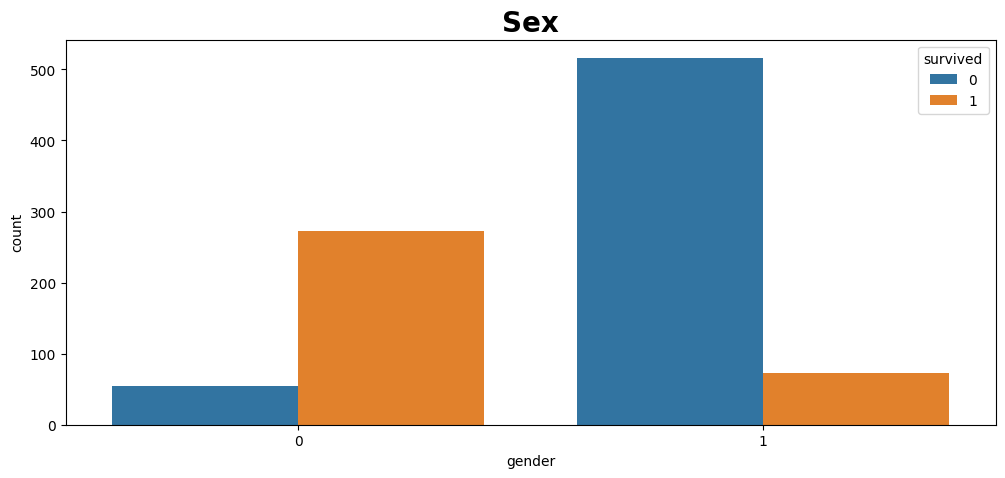

In [122]:
fig, axs = plt.subplots(figsize=(12, 5))
sns.countplot(x=X["gender"], hue='survived', data=X).set_title("Sex",fontdict= { 'fontsize': 20, 'fontweight':'bold'});

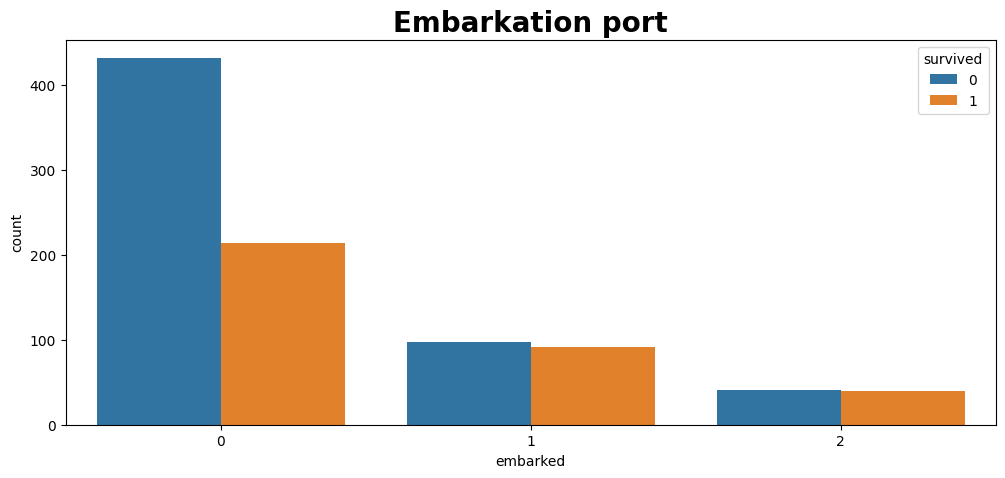

In [123]:
fig, axs = plt.subplots(figsize=(12, 5))
sns.countplot(x=X["embarked"], hue='survived', data=X).set_title("Embarkation port",fontdict= { 'fontsize': 20, 'fontweight':'bold'});

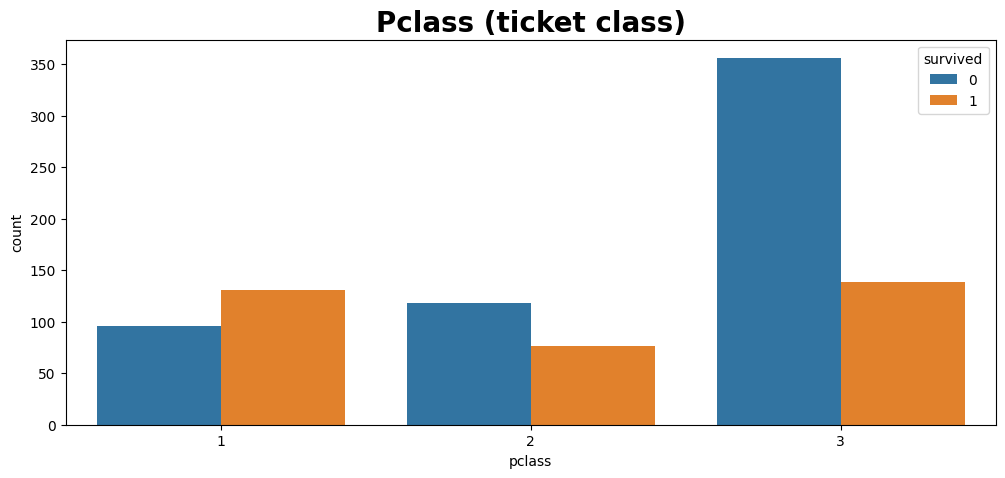

In [124]:
# Pclass analysis
fig, axs = plt.subplots(figsize=(12, 5))
sns.countplot(x=X["pclass"], hue='survived', data=X).set_title("Pclass (ticket class)",fontdict= { 'fontsize': 20, 'fontweight':'bold'});

In [125]:
# Feature extraction

# name column
# Many people had titles in their names, which might be interesting indicators about their social and/or economical status, thus this could influence their survival chances

# I extract alphanumericals that are exactly before the fullstop for every name, and a make a new column with them for every passenger for both X and X_test_data
X['Title'] = X.name.str.extract('([A-Za-z]+)\.', expand = False)
X_test_data['Title'] = X_test_data.name.str.extract('([A-Za-z]+)\.', expand = False)

X.Title.value_counts()
# As we can see, Mr, Miss, Mrs, Master

# All rare titles will be aliased as "Rare" in our new column to prevent overfitting
rare_titles = ['Rev','Dr','Major','Col','Capt','Jonkheer','Countess']
X.Title = X.Title.replace(rare_titles,'Rare')
X_test_data.Title = X_test_data.Title.replace(rare_titles,'Rare')

# I will label encode the new feature now in both X and X_test_data
X['Title'] = LabelEncoder().fit_transform(X['Title']) 
X_test_data['Title'] = LabelEncoder().fit_transform(X_test_data['Title']) 

In [127]:
# FamilyMembers (SibSp and Parch)

# I get the total number of each family adding SibSp and Parch. (+1) is the same passenger for both X and X_test_data.

# For X
X['FamilyMembers'] = X['sibsp'] + X['parch']+1
X.drop(['sibsp','parch'], axis = 1, inplace = True)

# For X_test_data
X_test_data['FamilyMembers'] = X_test_data['sibsp'] + X_test_data['parch']+1
X_test_data.drop(['sibsp','parch'], axis = 1, inplace = True)

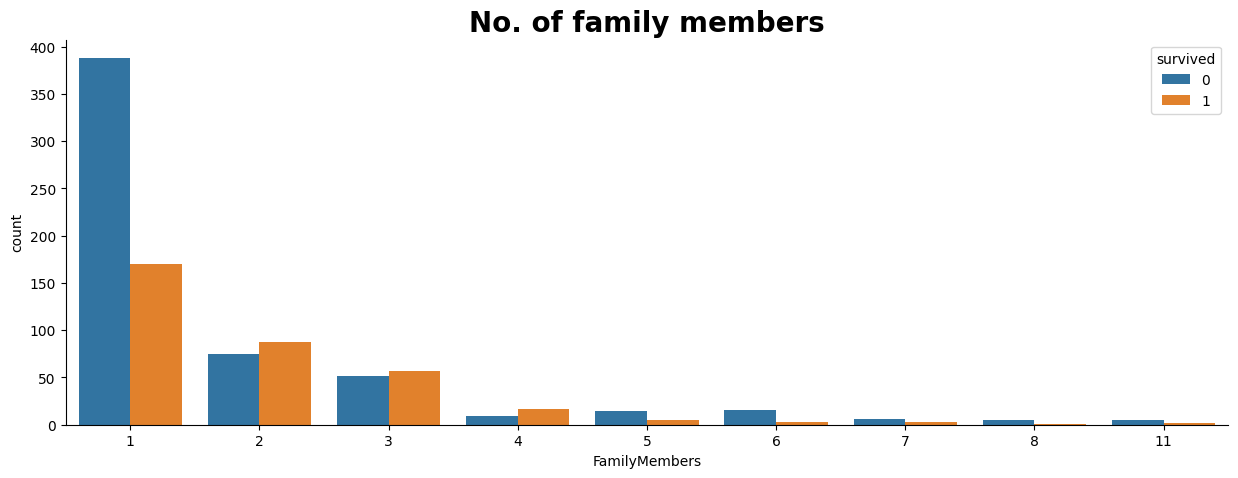

In [128]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x='FamilyMembers', hue='survived', data=X).set_title("No. of family members",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
sns.despine()

In [129]:
# I will bin this feature to prevent overfitting by having way too many catgories with a pretty small number each
# Binning the column in X
X.loc[ X['FamilyMembers'] == 1, 'FamilyMembers'] = 0                            
X.loc[(X['FamilyMembers'] > 1) & (X['FamilyMembers'] <= 4), 'FamilyMembers'] = 1  
X.loc[(X['FamilyMembers'] > 4) & (X['FamilyMembers'] <= 6), 'FamilyMembers'] = 2  
X.loc[X['FamilyMembers']  > 6, 'FamilyMembers'] = 3 

# Binning the column in X_test_data
X_test_data.loc[ X_test_data['FamilyMembers'] == 1, 'FamilyMembers'] = 0                            
X_test_data.loc[(X_test_data['FamilyMembers'] > 1) & (X_test_data['FamilyMembers'] <= 4), 'FamilyMembers'] = 1  
X_test_data.loc[(X_test_data['FamilyMembers'] > 4) & (X_test_data['FamilyMembers'] <= 6), 'FamilyMembers'] = 2  
X_test_data.loc[X_test_data['FamilyMembers']  > 6, 'FamilyMembers'] = 3 

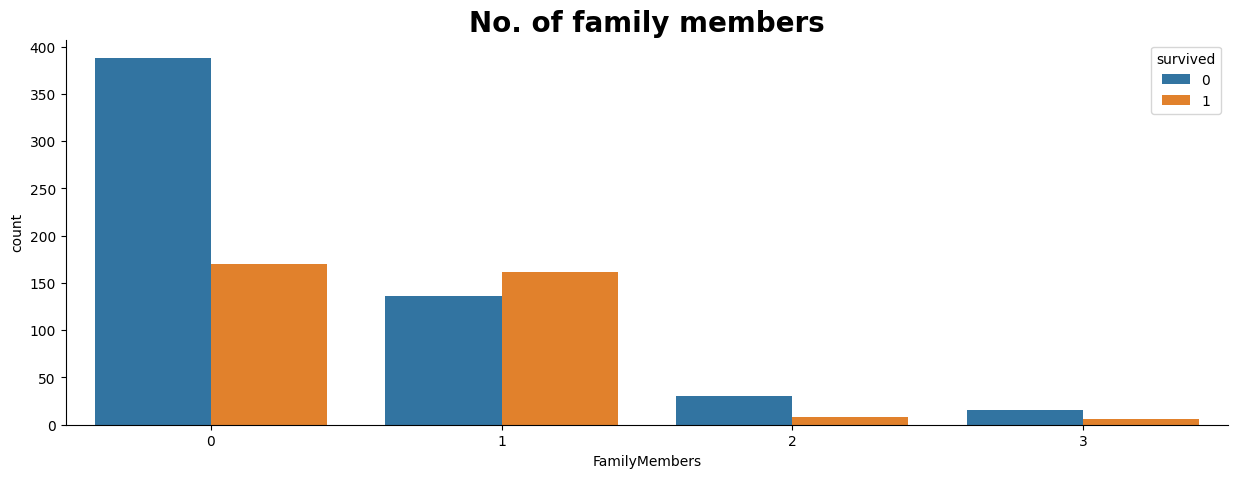

In [131]:
# I plot the feature again
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x='FamilyMembers', hue='survived', data=X).set_title("No. of family members",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
sns.despine()

In [134]:
# As we saw in the plot with the AgeBins, the age group 0-10 years old passengers (0) is the only groups that survivors were more than non-survivors. Also, in the Sex plot we saw that most women survived and that most men died, so we conclude that being female and a child means a better chance of survival than being male and not a child. Thus, i will make a new feature "FemAndChild"

# In X
X["FemAndChild"] = ((X.agebins == 0) | (X.gender == 1))
# In X_test_data
X_test_data["FemAndChild"] = ((X_test_data.agebins == 0) | (X_test_data.gender == 1))

# If the passenger is female and child, the i assign 1, and if not, i assign 0
# In X
X.loc[ X['FemAndChild'] == True, 'FemAndChild'] = 1  
X.loc[ X['FemAndChild'] == False, 'FemAndChild'] = 0  

# In X_test_data
X_test_data.loc[ X_test_data['FemAndChild'] == True, 'FemAndChild'] = 1  
X_test_data.loc[ X_test_data['FemAndChild'] == False, 'FemAndChild'] = 0 

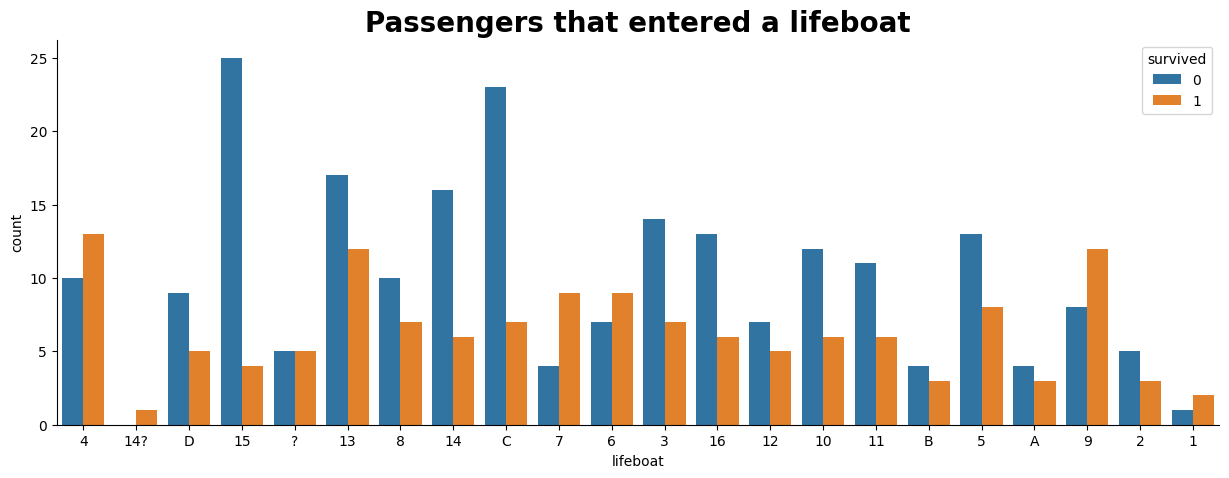

In [137]:
# Lifeboat analysis
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x='lifeboat', hue='survived', data=X).set_title("Passengers that entered a lifeboat",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
sns.despine()

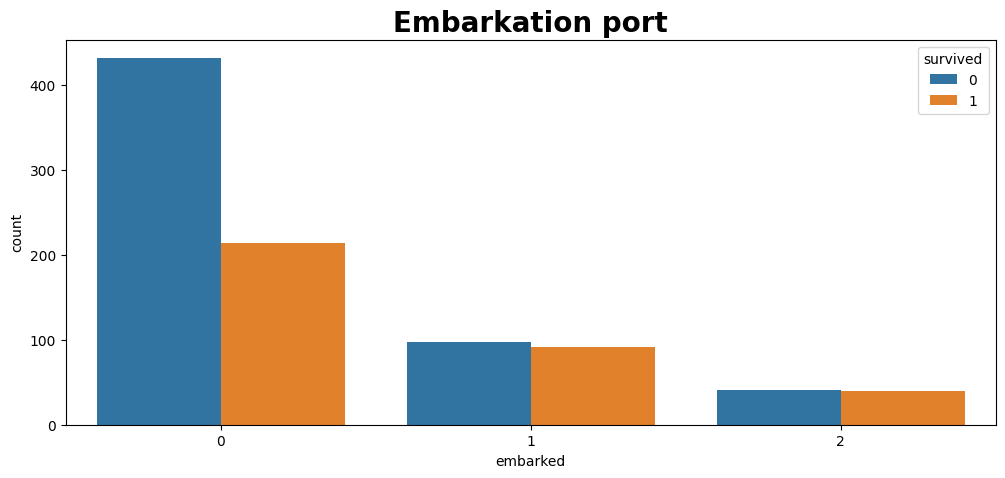

In [138]:
fig, axs = plt.subplots(figsize=(12, 5))
sns.countplot(x=X["embarked"], hue='survived', data=X).set_title("Embarkation port",fontdict= { 'fontsize': 20, 'fontweight':'bold'});

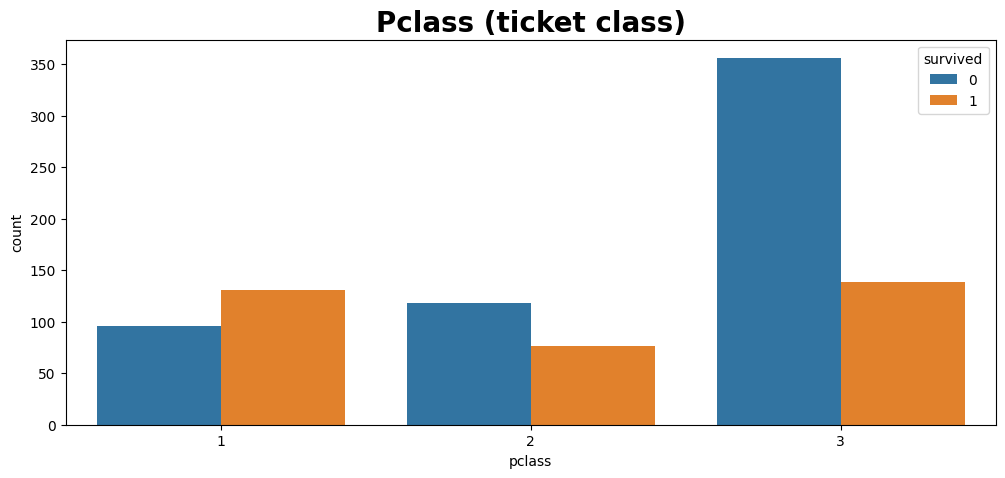

In [139]:
# Pclass analysis
fig, axs = plt.subplots(figsize=(12, 5))
sns.countplot(x=X["pclass"], hue='survived', data=X).set_title("Pclass (ticket class)",fontdict= { 'fontsize': 20, 'fontweight':'bold'});

In [140]:
# Feature extraction

# Name column
# Many people had titles in their names, which might be interesting indicators about their social and/or economical status, thus this could influence their survival chances

# I extract alphanumericals that are exactly before the fullstop for every name, and a make a new column with them for every passenger for both X and X_test_data
X['Title'] = X.name.str.extract('([A-Za-z]+)\.', expand = False)
X_test_data['Title'] = X_test_data.name.str.extract('([A-Za-z]+)\.', expand = False)

X.Title.value_counts()
# As we can see, Mr, Miss, Mrs, Master

# All rare titles will be aliased as "Rare" in our new column to prevent overfitting
rare_titles = ['Rev','Dr','Major','Col','Capt','Jonkheer','Countess']
X.Title = X.Title.replace(rare_titles,'Rare')
X_test_data.Title = X_test_data.Title.replace(rare_titles,'Rare')

# I will label encode the new feature now in both X and X_test_data
X['Title'] = LabelEncoder().fit_transform(X['Title']) 
X_test_data['Title'] = LabelEncoder().fit_transform(X_test_data['Title']) 

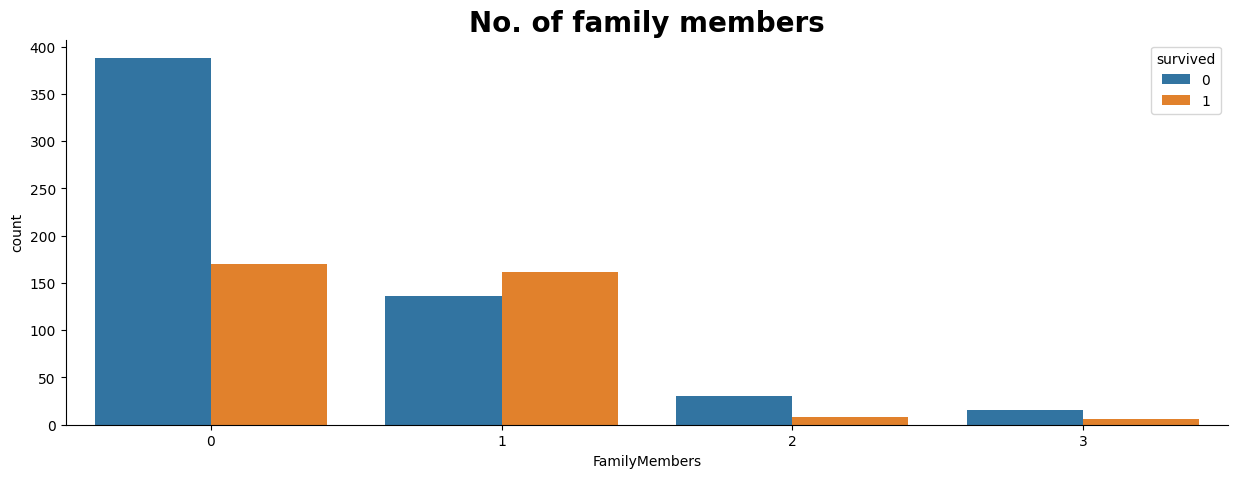

In [142]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x='FamilyMembers', hue='survived', data=X).set_title("No. of family members",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
sns.despine()

In [144]:
# I will bin this feature to prevent overfitting by having way too many catgories with a pretty small number each
# Binning the column in X
X.loc[ X['FamilyMembers'] == 1, 'FamilyMembers'] = 0                            
X.loc[(X['FamilyMembers'] > 1) & (X['FamilyMembers'] <= 4), 'FamilyMembers'] = 1  
X.loc[(X['FamilyMembers'] > 4) & (X['FamilyMembers'] <= 6), 'FamilyMembers'] = 2  
X.loc[X['FamilyMembers']  > 6, 'FamilyMembers'] = 3 

# Binning the column in X_test_data
X_test_data.loc[ X_test_data['FamilyMembers'] == 1, 'FamilyMembers'] = 0                            
X_test_data.loc[(X_test_data['FamilyMembers'] > 1) & (X_test_data['FamilyMembers'] <= 4), 'FamilyMembers'] = 1  
X_test_data.loc[(X_test_data['FamilyMembers'] > 4) & (X_test_data['FamilyMembers'] <= 6), 'FamilyMembers'] = 2  
X_test_data.loc[X_test_data['FamilyMembers']  > 6, 'FamilyMembers'] = 3 

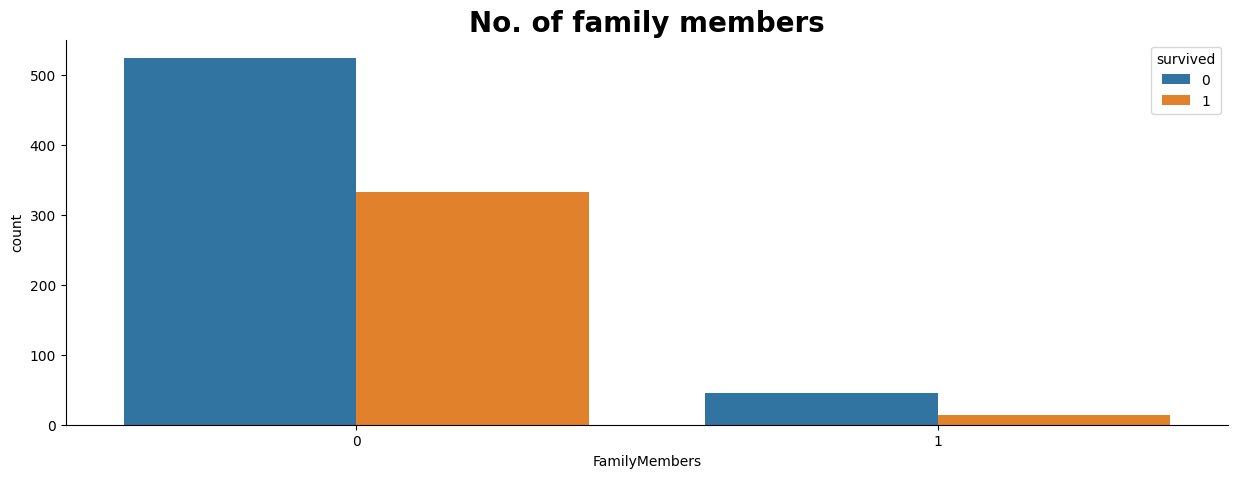

In [146]:
# I plot the feature again
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x='FamilyMembers', hue='survived', data=X).set_title("No. of family members",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
sns.despine()

In [148]:
# As we saw in the plot with the AgeBins, the age group 0-10 years old passengers (0) is the only groups that survivors were more than non-survivors. Also, in the Sex plot we saw that most women survived and that most men died, so we conclude that being female and a child means a better chance of survival than being male and not a child. Thus, i will make a new feature "FemAndChild"

# In X
X["FemAndChild"] = ((X.agebins == 0) | (X.gender == 1))
# In X_test_data
X_test_data["FemAndChild"] = ((X_test_data.agebins == 0) | (X_test_data.gender == 1))

# If the passenger is female and child, the i assign 1, and if not, i assign 0
# In X
X.loc[ X['FemAndChild'] == True, 'FemAndChild'] = 1  
X.loc[ X['FemAndChild'] == False, 'FemAndChild'] = 0  

# In X_test_data
X_test_data.loc[ X_test_data['FemAndChild'] == True, 'FemAndChild'] = 1  
X_test_data.loc[ X_test_data['FemAndChild'] == False, 'FemAndChild'] = 0 

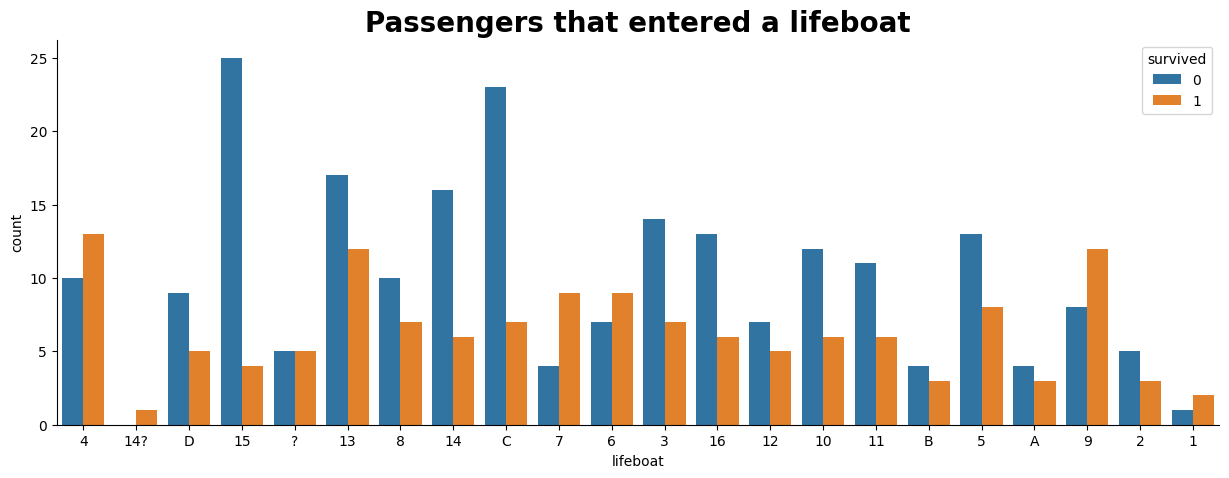

In [149]:
# Lifeboat analysis
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x='lifeboat', hue='survived', data=X).set_title("Passengers that entered a lifeboat",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
sns.despine()

In [150]:
# Here i make a new feature "AccesToLifeboat" which is equal to 0 if the person did not had access to a lifeboat, and equal to 1 if the person had access
for i in X["lifeboat"]:
    X['AccessToLifeboat'] = (X['lifeboat'].notnull().astype('int'))

for i in X_test_data["lifeboat"]:
    X_test_data['AccessToLifeboat'] = (X_test_data['lifeboat'].notnull().astype('int'))   

# Now i can safely drop th original "Lifeboat" column
X.drop(["lifeboat"], axis=1, inplace=True)
X_test_data.drop(["lifeboat"], axis=1, inplace=True)

In [151]:
print(X.info())
print(X_test_data.info())
print(X.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   passengerid       916 non-null    int64  
 1   survived          916 non-null    int64  
 2   pclass            916 non-null    int64  
 3   name              916 non-null    object 
 4   gender            916 non-null    int64  
 5   age               916 non-null    float64
 6   ticket            916 non-null    object 
 7   fare              916 non-null    float64
 8   embarked          916 non-null    int64  
 9   Hascabin          916 non-null    int64  
 10  agebins           916 non-null    int64  
 11  farebins          916 non-null    int64  
 12  Title             916 non-null    int64  
 13  FamilyMembers     916 non-null    int64  
 14  FemAndChild       916 non-null    object 
 15  AccessToLifeboat  916 non-null    int64  
dtypes: float64(2), int64(11), object(3)
memory u

In [152]:
X.drop(['name', 'ticket'], axis = 1, inplace = True)
X_test_data.drop(['name', 'ticket'], axis = 1, inplace = True)

print(X.info())
print(X_test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   passengerid       916 non-null    int64  
 1   survived          916 non-null    int64  
 2   pclass            916 non-null    int64  
 3   gender            916 non-null    int64  
 4   age               916 non-null    float64
 5   fare              916 non-null    float64
 6   embarked          916 non-null    int64  
 7   Hascabin          916 non-null    int64  
 8   agebins           916 non-null    int64  
 9   farebins          916 non-null    int64  
 10  Title             916 non-null    int64  
 11  FamilyMembers     916 non-null    int64  
 12  FemAndChild       916 non-null    object 
 13  AccessToLifeboat  916 non-null    int64  
dtypes: float64(2), int64(11), object(1)
memory usage: 100.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
D

In [159]:
X.drop(['passengerid'], axis=1, inplace=True)

In [168]:
pclass_hot = pd.get_dummies(X.pclass, drop_first=True)
# drop_first=True 는 첫번째 옵션을 drop함을 뜻합니다.
# 예로 Sex column에서 female이 1이라면, 0인 row는 자동으로 male을 의미하게 됩니다.

X = pd.concat([X, pclass_hot], axis=1)
X.drop(['pclass'], axis=1, inplace=True)

pclass_hot = pd.get_dummies(X_test_data.pclass, drop_first=True)
# drop_first=True 는 첫번째 옵션을 drop함을 뜻합니다.
# 예로 Sex column에서 female이 1이라면, 0인 row는 자동으로 male을 의미하게 됩니다.

X_test_data = pd.concat([X_test_data, pclass_hot], axis=1)
X_test_data.drop(['pclass'], axis=1, inplace=True)

In [171]:
passengerid = X_test_data.drop(['passengerid'], axis=1, inplace=True)

In [173]:
X_test_data

,gender,age,fare,embarked,Hascabin,agebins,farebins,Title,FamilyMembers,FemAndChild,AccessToLifeboat,2,3
0,0,15.000000,8.0292,2,0,1,0,3,0,0,0,0,1
1,0,32.000000,13.0000,0,0,3,0,7,0,0,0,1,0
2,0,23.463415,7.7500,2,0,2,0,3,0,0,1,0,1
3,1,25.941538,7.2500,0,0,2,0,6,0,1,1,0,1
4,0,45.000000,164.8667,0,0,4,1,7,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,0,23.463415,7.7500,2,0,2,0,3,0,0,1,0,1
389,0,16.000000,57.9792,1,1,1,0,3,0,0,0,0,0
390,0,13.000000,7.2292,1,0,1,0,3,0,0,1,0,1
391,0,39.000000,31.2750,0,0,3,0,7,1,0,1,0,1


In [177]:
X.drop([2, 3], axis=1, inplace=True)

In [179]:
X_test_data.drop([2, 3], axis=1, inplace=True)

In [180]:
from sklearn.preprocessing import QuantileTransformer

# QuantileTransformer + 정규분포 형태로 변환
scaler = QuantileTransformer(output_distribution = 'normal')

X_scaled = scaler.fit_transform(X)
#해당 fit으로 test데이터도 transform 해줍니다
X_test_scaled = scaler.transform(X_test_data)

In [182]:
X_test_scaled

array([[-5.19933758, -1.38477846, -0.61022498, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [-5.19933758,  0.4247235 , -0.12773252, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [-5.19933758, -0.46262124, -1.09068881, ..., -5.19933758,
        -5.19933758,  5.19933758],
       ...,
       [-5.19933758, -1.46010108, -1.44827204, ..., -5.19933758,
        -5.19933758,  5.19933758],
       [-5.19933758,  0.8069902 ,  0.71724321, ...,  5.19933758,
        -5.19933758,  5.19933758],
       [-5.19933758,  0.01506773, -0.83577998, ..., -5.19933758,
        -5.19933758,  5.19933758]])

In [183]:
# Modelling

warnings.filterwarnings(action='ignore')

#X['FemAndChild'] = pd.to_numeric(X['FemAndChild'])
#X_test_data['FemAndChild'] = pd.to_numeric(X_test_data['FemAndChild'])


#X.drop(['survived'], axis=1, inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, train_size=0.7, test_size=0.3, random_state=0, stratify=y)

In [162]:
y = train_df.survived.values

In [184]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

Y_pred = logreg.predict(X_valid)
cprint("Accuracy of the model with train and validation data is : ", "green")
accuracy_score(y_valid, Y_pred)

Accuracy of the model with train and validation data is : 


0.8581818181818182